In [1]:
import pickle
import numpy as np
import pandas as pd
import warnings

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')

In [ ]:
#from lenskit.datasets import ML100K

# Load Data

In [2]:
pkl = open('movie_datas.pkl','rb')
read_datas = pickle.load(pkl)
pkl.close()

In [3]:
data = read_datas[['user','item','rating','timestamp', 'age', 'gender', 'occupation','zip', 'release', 'Action','Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime','Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical','Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]

# Cleaning

In [4]:
data.drop(['timestamp', 'zip'], axis=1, inplace=True)

In [5]:
le_gender = preprocessing.LabelEncoder()
le_gender.fit(data.loc[:, 'gender'])
data['gender'] = le_gender.transform(data['gender'])

le_occupation = preprocessing.LabelEncoder()
le_occupation.fit(data.loc[:, 'occupation'])
data['occupation'] = le_occupation.transform(data['occupation'])

In [6]:
data = data[data.item != 267]
data = data.reset_index()

In [7]:
d = data.copy()
for i in range(data.release.size):
    s = str(data.release[i])
    try:
        d.release[i] = int(s[-4:])
    except:
        d.release[i] = np.nan

In [8]:
data = d.copy()

In [9]:
data.release = data.release.astype("int")

In [10]:
data.drop(['index'], axis=1, inplace=True)

In [11]:
data.head()

,user,item,rating,age,gender,occupation,release,Action,Adventure,Animation,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3.0,49,1,20,1997,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3.0,39,0,6,1997,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1.0,25,1,20,1994,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2.0,28,1,19,1994,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1.0,47,1,3,1997,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Creating clean data

In [12]:
filename = 'cleaned_movie_data.pkl'
outfile = open(filename,'wb')

In [13]:
pickle.dump(data,outfile)
outfile.close()

# Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
X = data.copy()
X.drop(['rating','item','occupation','user'], axis=1, inplace=True)

In [17]:
y_ = data.rating.copy()
y__ = [round(e) for e in y_]
y = [0 if e < 4 else 1 for e in y__]

In [18]:
X_train, X_test = X.iloc[:80000], X.iloc[80000:]
y_train, y_test = y[:80000], y[80000:]

In [19]:
clf = RandomForestClassifier(max_depth=7, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, random_state=0)

In [20]:
prediction = clf.predict(X_test)

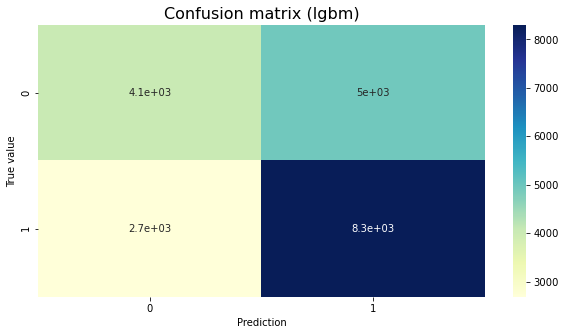

In [21]:
df_cm = pd.DataFrame(confusion_matrix(y_test, prediction))
df_cm.index.name = 'True value'
df_cm.columns.name = 'Prediction'
plt.figure(figsize=(10, 5))
plt.title('Confusion matrix (lgbm)', fontsize=16)
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

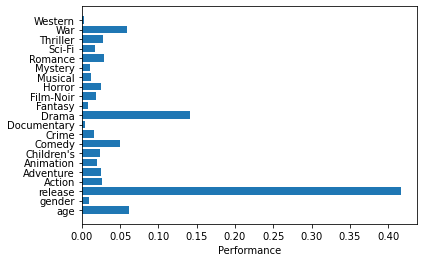

In [22]:
fig, ax = plt.subplots()
ax.barh(np.arange(clf.n_features_), clf.feature_importances_, align='center')
ax.set_yticks(np.arange(clf.n_features_))
ax.set_yticklabels(X_test.columns)
ax.set_xlabel('Performance')

plt.show()

In [23]:
def plt_bar(data, clf):
    fig, ax = plt.subplots()
    ax.barh(np.arange(clf.n_features_), clf.feature_importances_, align='center')
    ax.set_yticks(np.arange(clf.n_features_))
    ax.set_yticklabels(data.columns)
    ax.set_xlabel('Performance')

    plt.show()

# Dialog

- Trouver la variable la plus déterminante
- Poser la question concernant cette variable (variables quantitatives?)
- Récupérer la réponse
- Récupérer l'ensemble de datas restant correspondant à la réponse
- Réitérer jusqu'à obtenir convergence / 7 coups
- Choisir un/des film parmi ceux qui restent (ceux avec la meilleure moyenne sur les datas telles qu'elles sont par exemple

In [24]:
def most_important_feature(X, y, max_depth=7):
    clf = RandomForestClassifier(max_depth=max_depth, random_state=0)
    clf.fit(X, y)
    v = X.columns[np.argmax(clf.feature_importances_)]
    return clf, v
    
def question_from_v(variable, question_dict, threshold=0):
    if len(question_dict[variable]) == 0:
        return "Do you like " + variable + " movies? (y/n)"
    if threshold <= 1:
        return question_dict[variable]
    return question_dict[variable] + str(threshold) + "? (y/n)"
    
def data_without_v(data, variable, value, lower=True):
    d = data.copy()
    if lower:
        d = d[d[variable] < value]
    else:
        d = d[d[variable] > value]
    return d

def get_X(data):
    X = data.copy()
    X.drop(['rating','item','user'], axis=1, inplace=True)
    return X

def get_y(data):
    y_ = data.rating.copy()
    y__ = [round(e) for e in y_]
    y = [0 if e < 4 else 1 for e in y__]
    return y

def get_item_names(movies, items):
    names = []
    for i in items:
        names.append(movies.iloc[i-1].title)
    return names

In [25]:
def get_movies_scores(data):
    scores_data = {
        "item" : data.item.unique(),
        "score" : [np.mean(data[data.item == item].rating) for item in data.item.unique()]
    }
    movies_scores = pd.DataFrame(scores_data, columns = ['item','score'])
    movies_scores = movies_scores.sort_values(by="score",ascending=False)
    return movies_scores

In [48]:
def remove_empty_variables(data):
    for v in data.columns:
        avg = np.mean(data[v])
        if data[data[v] > avg].size == 0 or data[data[v] <= avg].size == 0 :
            data.drop([v], axis=1, inplace=True)

In [49]:
question_dict = {
    'release' : "Do you prefer movies more recent than ",
    'age' : "Are you older than ",
    'gender' : "Are you a man? (y/n)",
    'Action' : "",
    'Adventure' : "",
    'Animation' : "",
    'Children\'s' : "",
    'Comedy' : "",
    'Crime' : "",
    'Documentary' : "",
    'Drama' : "",
    'Fantasy' : "",
    'Film-Noir' : "",
    'Horror' : "",
    'Musical' : "",
    'Mystery' : "",
    'Romance' : "",
    'Sci-Fi' : "",
    'Thriller' : "",
    'War' : "",
    'Western' : "",
}

In [64]:
#data.drop(['age', 'gender','occupation'], axis=1, inplace=True)

In [73]:
def random_questions(data):
    new_data = data.copy()
    while new_data.item.unique().size > 10:
        #remove_empty_variables(data)
        X, y = get_X(new_data), get_y(new_data)
        clf, v = most_important_feature(X, y, max_depth=7)
        #plt_bar(X, clf)
        avg = np.mean(new_data[v])
        lower = False
        middle = (avg) / (0.01 + np.max(new_data[v]) - np.min(new_data[v]))
        if np.random.rand() < middle:
            lower = True
        new_data = data_without_v(new_data, v, avg, lower=lower)
        new_data.drop([v], axis=1, inplace=True)
    return new_data.item.unique()

In [79]:
amount_found = np.zeros(data.item.unique().size)

In [80]:
for k in range(100):
    item_found = random_questions(data)
    for i in item_found:
        amount_found[i-1] += 1
    if len(item_found) == 0:
        print("0 trouvé")
    if k % 5 == 0:
        print("k = " + str(k))

k = 0
k = 5
k = 10
k = 15
k = 20
k = 25
k = 30
k = 35
k = 40
k = 45
k = 50
k = 55
k = 60
k = 65
k = 70
k = 75
k = 80
k = 85
k = 90
k = 95


(array([1661.,   12.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           8.]),
 array([ 0. ,  7.1, 14.2, 21.3, 28.4, 35.5, 42.6, 49.7, 56.8, 63.9, 71. ]),
 <a list of 10 Patch objects>)

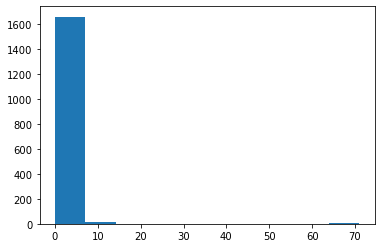

In [82]:
plt.hist(amount_found)

In [86]:
np.argmax(amount_found)

131

In [14]:
movies.iloc[171]

NameError: name 'movies' is not defined

In [83]:
amount_found.sum()

723.0

In [84]:
random_found = np.zeros(data.item.unique().size)

for k in range(int(amount_found.sum())):
    random_found[np.random.randint(0,data.item.unique().size-1)] += 1

(array([1086.,    0.,    0.,  479.,    0.,    0.,  104.,    0.,    0.,
          12.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

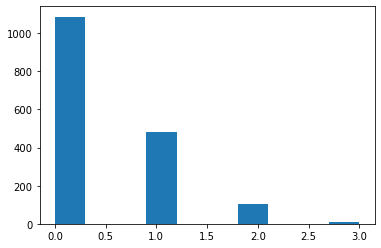

In [85]:
plt.hist(random_found)

In [35]:
def get_infos(array):
    print("mean : " + str(np.mean(array)) + "\nstd : " + str(np.std(array)) + "\nmax : " + str(np.max(array)))

In [36]:
get_infos(random_found)

mean : 0.02795954788816181
std : 0.16485694274143078
max : 1.0


In [37]:
get_infos(amount_found)

mean : 0.02795954788816181
std : 0.1884308561163428
max : 2.0


## Pour Aujourd'hui

- Faire le dico de questions
- Faire une fonction qui donne les solutions
- Faire le processus complet interactif
- Compter lesquels tombent le plus souvent
- Ajouter un option "indifférent" qui supprime la variable de la base

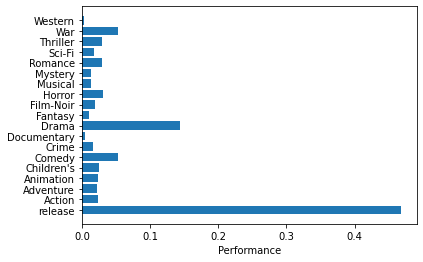

Do you prefer movies more recent than 1987? (y/n)y
1374


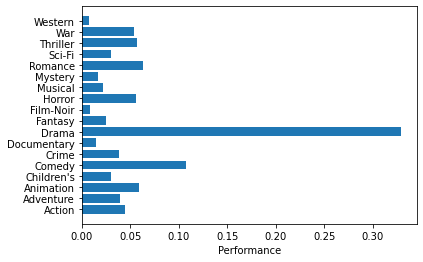

Do you like Drama movies? (y/n)y
614


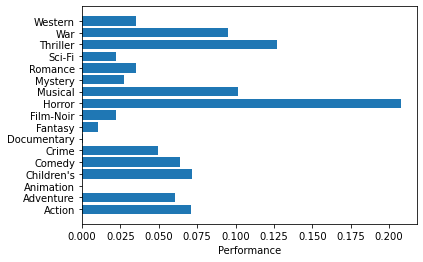

Do you like Horror movies? (y/n)y
5


In [60]:
new_data = data.copy()

while new_data.item.unique().size > 10 and len(new_data.columns) > 1:
    remove_empty_variables(data)
    
    X, y = get_X(new_data), get_y(new_data)
    clf, v = most_important_feature(X, y, max_depth=7)
    plt_bar(X, clf)
    avg = np.mean(X[v])
    if avg > 1:
        avg = int(avg)
    y_or_n = input(question_from_v(v, question_dict, threshold=avg))
    if y_or_n == "y" or y_or_n == "Y" or y_or_n == "yes" or y_or_n == "Yes" :
        new_data = data_without_v(new_data, v, avg, lower=False)
    elif y_or_n == "n" or y_or_n == "N" or y_or_n == "no" or y_or_n == "No" :
        new_data = data_without_v(new_data, v, avg, lower=True)
    new_data.drop([v], axis=1, inplace=True)
    
    print(new_data.item.unique().size)

In [59]:
movies_scores = get_movies_scores(new_data)
get_item_names(movies, movies_scores.item)

['Dances with Wolves (1990)',
 'Batman (1989)',
 'White Squall (1996)',
 'War, The (1994)',
 'First Knight (1995)',
 'Free Willy (1993)',
 'Buddy (1997)',
 'Free Willy 2: The Adventure Home (1995)',
 'Free Willy 3: The Rescue (1997)']

In [59]:
new_data

,user,item,rating,Action,Animation,Children's,Comedy,Crime,Documentary,Fantasy,Film-Noir,Mystery,Romance,Sci-Fi,Thriller,Western
107,271,132,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0
569,288,132,3.0,0,0,1,0,0,0,0,0,0,0,0,0,0
1503,290,132,3.0,0,0,1,0,0,0,0,0,0,0,0,0,0
1694,293,132,4.0,0,0,1,0,0,0,0,0,0,0,0,0,0
1695,62,132,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98839,716,132,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0
99307,776,132,3.0,0,0,1,0,0,0,0,0,0,0,0,0,0
99329,542,132,3.0,0,0,1,0,0,0,0,0,0,0,0,0,0
99537,804,132,4.0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [33]:
ratings = pd.read_csv('BX-CSV-Dump/BX-Book-Ratings.csv', delimiter=";", encoding="latin1")
ratings.columns = ['userId', 'ISBN', 'bookRating']

In [32]:
users = pd.read_csv('BX-CSV-Dump/BX-Users.csv', delimiter=";", encoding="latin1")
users.columns = ['userId', 'location', 'age']

In [31]:
books = pd.read_csv('BX-CSV-Dump/BX-Books.csv', delimiter=";", encoding="latin-1", error_bad_lines=False)
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageURLS', 'imageURLM', 'imageURLL']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [34]:
books.columns

Index(['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher',
       'imageURLS', 'imageURLM', 'imageURLL'],
      dtype='object')